<a href="https://www.kaggle.com/code/eduus710/store-sales-baseline?scriptVersionId=96031231" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Store Sales - Time Series Forecasting: Baseline Model

This is a short notebook that builds a couple of simple models as a performance baseline for the Store Sales competition.

- Mean: for each store/family, use the mean of the prior $n$ weeks sales as the prediction for future dates
- WeekDay Mean: for each store/family/week_day, use the mean of the prior $n$ weeks as the prediction for 
future dates (i.e. use the average of the last 3 sundays to predict future sundays for each store/family combination)

We'll use scikit cross-validation to assess performance, so we'll create a fold generator, and wrap our models as estimators.

In [21]:
from pathlib import Path
from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

simplefilter("ignore")
comp_dir = Path('../input/store-sales-time-series-forecasting')

import os
for dirname, _, filenames in os.walk(comp_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/store-sales-time-series-forecasting/oil.csv
../input/store-sales-time-series-forecasting/sample_submission.csv
../input/store-sales-time-series-forecasting/holidays_events.csv
../input/store-sales-time-series-forecasting/stores.csv
../input/store-sales-time-series-forecasting/train.csv
../input/store-sales-time-series-forecasting/test.csv
../input/store-sales-time-series-forecasting/transactions.csv


#### Load training and test datasets

In [22]:
def load_training_data(input_dir):
    train = pd.read_csv(
        input_dir / 'train.csv',
        usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
        dtype={
            'store_nbr': 'category',
            'family': 'category',
            'sales': 'float32',
            'onpromotion': 'uint32',
        },
        parse_dates=['date'],
        infer_datetime_format=True,
    )
    train['date'] = train.date.dt.to_period('D')
    train = train.set_index(['store_nbr', 'family', 'date']).sort_index()
    return train

def load_test_data(input_dir):
    test = pd.read_csv(
        input_dir / 'test.csv',
        dtype={
            'id': 'uint32',
            'store_nbr': 'category',
            'family': 'category',
            'onpromotion': 'uint32',
        },
        parse_dates=['date'],
        infer_datetime_format=True,
    )
    test['date'] = test.date.dt.to_period('D')
    test = test.set_index(['store_nbr', 'family', 'date']).sort_index()
    return test

In [23]:
train = load_training_data(comp_dir)
test = load_test_data(comp_dir)
y = train['sales']
X = train.drop(columns=['sales'])
display(X)
display(y)

onpromotion
store_nbr family     date                   
1         AUTOMOTIVE 2013-01-01            0
                     2013-01-02            0
                     2013-01-03            0
                     2013-01-04            0
                     2013-01-05            0
...                                      ...
9         SEAFOOD    2017-08-11            0
                     2017-08-12            4
                     2017-08-13            0
                     2017-08-14            0
                     2017-08-15            0

[3000888 rows x 1 columns]

store_nbr  family      date      
1          AUTOMOTIVE  2013-01-01     0.000000
                       2013-01-02     2.000000
                       2013-01-03     3.000000
                       2013-01-04     3.000000
                       2013-01-05     5.000000
                                       ...    
9          SEAFOOD     2017-08-11    23.830999
                       2017-08-12    16.859001
                       2017-08-13    20.000000
                       2017-08-14    17.000000
                       2017-08-15    16.000000
Name: sales, Length: 3000888, dtype: float32

#### Scorer for cross-validation

I don't think scikit offers rmsle as a scoring option out-of-the-box

In [24]:
from sklearn.metrics import make_scorer

def rmsle(y, yhat):
    y = y.to_numpy()
    yhat = yhat.to_numpy()
    return np.sqrt(np.mean((np.log1p(yhat)-np.log1p(y))**2))

nrmsle_scorer = make_scorer(rmsle, greater_is_better=False)

#### Fold generator for cross validation

We are going to model all store/family series in one shot, so here we create all the folds for 
all the series in one pass.


In [25]:
class MultiSeriesKFold:
    def __init__(self, n_splits, n_test, n_train):
        """
        n_splits: number of folds
        n_test: test size for one series/fold
        n_train: training set size for one series/fold
        """
        self.n_splits = n_splits
        self.n_test = n_test
        self.n_train = n_train

    def split(self, X, y, groups=None):
        """
        X,y: assume indexed by store_nbr+family+date
        
        returns: generator yielding train,test pairs
        """
        
        # figure the number of product/family series and the size of the series
        n_series = len(X.index.unique(level=0)) * len(X.index.unique(level=1))
        n_obs = len(X.index) // n_series
        
        # make sure all series of same size
        assert n_obs * n_series == len(X.index)
        
        for split in range(1,self.n_splits+1):
            train, test = np.empty(0,np.int_), np.empty(0, np.int_)
            for i in range(n_series):
                # process the tail of each series to extract train and test for current fold
                offset = (i + 1) * n_obs - self.n_train - split * self.n_test
                train = np.append(train, np.arange(self.n_train) + offset)
                test = np.append(test, np.arange(self.n_test) + offset + self.n_train)
            yield train,test
                
    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

#### Mean Model

Use the mean of sales over prior $n$ weeks for each product/family as prediction for all
desired future dates. Again, we will estimate all product/family series in one pass from
the original full training set.

Here we wrap the model as a scikit estimator for use in cross-validation. 

In [26]:
from sklearn.base import RegressorMixin, BaseEstimator

class MeanRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, mean_weeks = 3):
        super().__init__()
        self.mean_weeks = mean_weeks
        self.mean_days = 7 * mean_weeks
    
    def fit(self, X, y):
        """
        X,y: assume indexed by store_nbr+family+date
        """
        self.target = f'{y.name}_hat'
        self.y_hat = y.groupby(level=[0,1]).tail(self.mean_days).groupby(level=[0,1]).mean().rename(self.target)
    
    def predict(self, X):
        """
        X: assume indexed by store_nbr+family+date
        
        returns: fitted mean predictions
        """
        return X.join(self.y_hat)[self.target]
        

#### Model Sanity Check

Plot model predictions vs truth as a sanity check. Here we plot a single store/family for clarity:
we expect a straight line prediction.

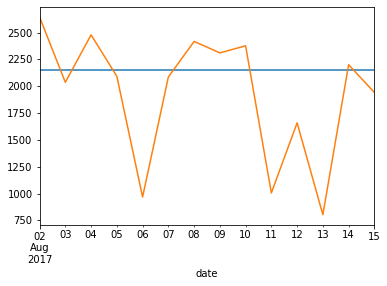

In [27]:
cvs = MultiSeriesKFold(1,14,100)
for train_idx, test_idx in cvs.split(X,y):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    model = MeanRegressor(mean_weeks=2)
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    y_hat['1','BEVERAGES'].plot()
    y_test['1','BEVERAGES'].plot()


#### Cross Validation

Run cross validation and get our first score.

In [28]:
from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(MeanRegressor(mean_weeks=2),
                             X, y, 
                             cv=MultiSeriesKFold(5,15,500), 
                             scoring=nrmsle_scorer)
cv_results.mean(), cv_results.std()

(-0.4782529234886169, 0.018913499292208792)

#### Weekday Mean Model

Another mean model, only this time we additionally group by the day of the week; e.g. we
will average of prior Sundays to predict future Sundays.

In [29]:
class WeekdayMeanRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, mean_weeks=3):
        super().__init__()
        self.mean_weeks = mean_weeks
        self.mean_days = 7 * mean_weeks
    
    def fit(self, X, y):
        """
        X,y: assume indexed by store_nbr+family+date
        """
        self.target = f'{y.name}_hat'
        # truncate to trailing mean_weeks observations
        y = y.groupby(level=[0,1]).tail(self.mean_days)
        
        # group by store/family/weekday and take the mean
        y = y.reset_index()
        y['weekday'] =  y.date.dt.weekday
        y = y.set_index(['store_nbr','family','date','weekday']).sort_index()
        self.y_hat = y.groupby(level=[0,1,3]).sales.mean()
        self.y_hat = self.y_hat.rename(self.target)
        
    def predict(self, X):
        """
        X: assume indexed by store_nbr+family+date
        
        returns: fitted mean predictions
        """
        # add weekday to index in order to join
        y = X.reset_index()
        y['weekday'] =  y.date.dt.weekday
        y = y.set_index(['store_nbr','family','weekday','date']).sort_index()
        y = y.join(self.y_hat)
        y = y.reset_index(level=2).sort_index()[self.target]
        return y


#### Sanity Check

Repeat the sanity check; here we expect to see variance across weekdays, hopefully in line with the actual values.

Looks about right...

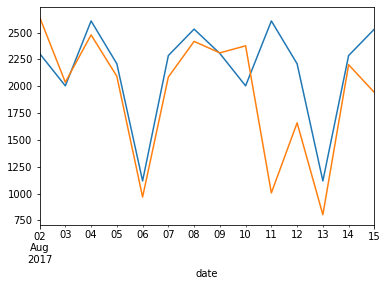

In [30]:
cvs = MultiSeriesKFold(1,14,100)
for train_idx, test_idx in cvs.split(X,y):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    model = WeekdayMeanRegressor(mean_weeks=2)
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    y_hat['1','BEVERAGES'].plot()
    y_test['1','BEVERAGES'].plot()

#### Cross Validation

Here we see a modest improvement in metric, though at the expense of a bit more variance
across the fold results

In [31]:
cv_results = cross_val_score(WeekdayMeanRegressor(mean_weeks=3),
                             X, y, 
                             cv=MultiSeriesKFold(5,15,500), 
                             scoring=nrmsle_scorer)
cv_results.mean(), cv_results.std()

(-0.4668246448040009, 0.03782211841149913)

#### Make a submission

Use our WeekdayMeanRegressor to generate a submission to give us a baseline score for future model comparisons.

In [32]:
model = WeekdayMeanRegressor(mean_weeks=3)
model.fit(X,y)
y_hat = model.predict(test)
display(y_hat)

store_nbr  family      date      
1          AUTOMOTIVE  2017-08-16     4.333333
                       2017-08-17     5.666667
                       2017-08-18     5.333333
                       2017-08-19     5.000000
                       2017-08-20     2.666667
                                       ...    
9          SEAFOOD     2017-08-27    21.639334
                       2017-08-28    17.544333
                       2017-08-29    16.997999
                       2017-08-30    18.735332
                       2017-08-31    14.923333
Name: sales_hat, Length: 28512, dtype: float32

In [33]:
submission = test.join(y_hat).set_index('id').sales_hat
submission = submission.rename('sales')
display(submission)
submission.to_csv('submission.csv')

id
3000888     4.333333
3002670     5.666667
3004452     5.333333
3006234     5.000000
3008016     2.666667
             ...    
3022271    21.639334
3024053    17.544333
3025835    16.997999
3027617    18.735332
3029399    14.923333
Name: sales, Length: 28512, dtype: float32